## name: Marco Giunta
### RLab07

In [3]:
library("tidyverse")

-- Attaching packages ------------------------------------------------------------------------------- tidyverse 1.3.1 --

v ggplot2 3.3.3     v purrr   0.3.4
v tibble  3.1.0     v dplyr   1.0.5
v tidyr   1.1.3     v stringr 1.4.0
v readr   1.4.0     v forcats 0.5.1

-- Conflicts ---------------------------------------------------------------------------------- tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()



## Ex. 1: blood test
### 1.1: binomial likelihood
If $y$ is the number of times the test fails to detect the disease in the patients then we can model $y$ as being sampled from a binomial likelihood, whose bias parameter $p$ is unknown to us initially and to be determined via inference.       
### 1.2: frequentist estimate of $p$
If we want to use a frequentist approach given the binomial likelihood it suffices to use the following equation:
\begin{equation}
  p_f = \frac{y}{n}
\end{equation}
where $y/n=6/75$ is the number of ill patients whose disease wasn't noticed by the test (i.e. the fraction of false negatives).           
This works because $y/n$ is an unbiased estimator of $p_{\text{true}}$ in the frequentist setting, as can be easily shown:
\begin{equation}
  \mathbb{E} (p_f) = \mathbb{E}\left(\frac{y}{n}\right) = \frac{\mathbb{E}(y)}{n} = \frac{np}{n} = p   \implies |\mathbb{E}(p_f) - p| = 0
\end{equation}
where $p$ is the "true" unknown but fixed value whose existence is assumed in the frequentist setting.          
Notice: the fact that $p$ can be estimated this way is an intuitive result if we consider that each test is essentially a Bernoulli trial and that probabilities in the frequentist approach are long run frequencies of the kind n. of successes/n. of attempts.

In [2]:
y <- 6
n <- 75
pf <- y/n

print(paste("frequentist estimate of p:", pf))

[1] "frequentist estimate of p: 0.08"


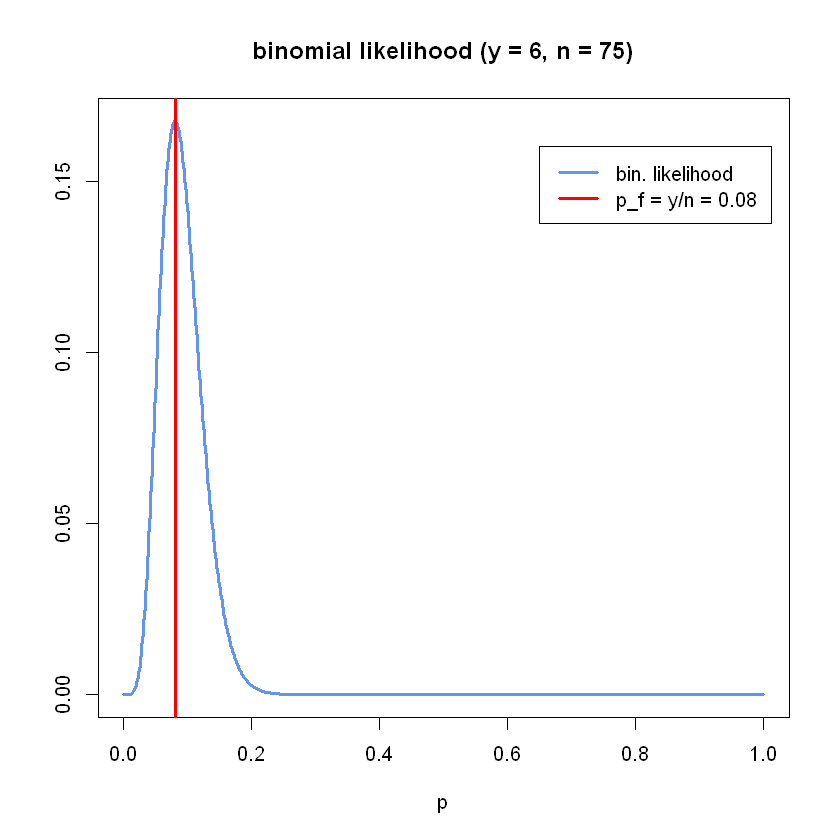

In [90]:
# notice that even if we didn't know the exact result mentioned above we could still obtain p_f
# using the MLE frequentist approach as follows

p.vector <- seq(0, 1, length.out = 1000)
binomial.likelihood <- function(p, y = 6, n = 75) dbinom(x = y, size = n, prob = p)

plot(p.vector, binomial.likelihood(p.vector), type = "l", col = "cornflowerblue", xlab = "p", ylab = "", main = "binomial likelihood (y = 6, n = 75)", lwd = 3)
abline(v = pf, col = "red", lwd = 2.5)
legend(x = 0.65, y = 0.16, legend = c("bin. likelihood" , sprintf("p_f = y/n = %.2f", pf)), lty = c(1,1), col = c("cornflowerblue", "red"), lwd = c(3, 2.5))

Notice that the binomial unbiased estimator is none other than the argmax of the binomial likelihood.

### 1.3: Bayesian inference of $p$
This time we use Bayes' theorem in the standard way using the prior defined in the exercise: a beta prior with mean 0.15 and sd 0.14 (we can compute the $\alpha, \beta$ parameters associated to this value using the formulae and code contained [here](https://stats.stackexchange.com/questions/12232/calculating-the-parameters-of-a-beta-distribution-using-the-mean-and-variance)).         
Once we know the values of the prior's $\alpha$ and $\beta$ we can compute the posterior's parameters using the usual simple update rules, since a beta prior is conjugate to the binomial likelihood; this means the new $\alpha', \beta'$ are given by:
\begin{equation}
  \alpha' = \alpha + y
\end{equation}
\begin{equation}
  \beta' = \beta + n - y
\end{equation}

In [20]:
estBetaParams <- function(mu, var) {
  alpha <- ((1 - mu) / var - 1 / mu) * mu ^ 2
  beta <- alpha * (1 / mu - 1)
  return(params = list(alpha = alpha, beta = beta))
}

prior.params <- estBetaParams(mu = 0.15, var = 0.14^2)
alpha.prior <- prior.params$alpha; beta.prior <- prior.params$beta
print(paste("prior alpha, beta parameters = ", alpha.prior, "and", beta.prior))

[1] "prior alpha, beta parameters =  0.825765306122449 and 4.67933673469388"


In [22]:
alpha.posterior <- alpha.prior + y; beta.posterior <- beta.prior + n - y
print(paste("posterior alpha, beta parameters = ", alpha.posterior, "and", beta.posterior))

[1] "posterior alpha, beta parameters =  6.82576530612245 and 73.6793367346939"


[1] "most probable value for p (MAP estimator) = 0.0740740740740741"


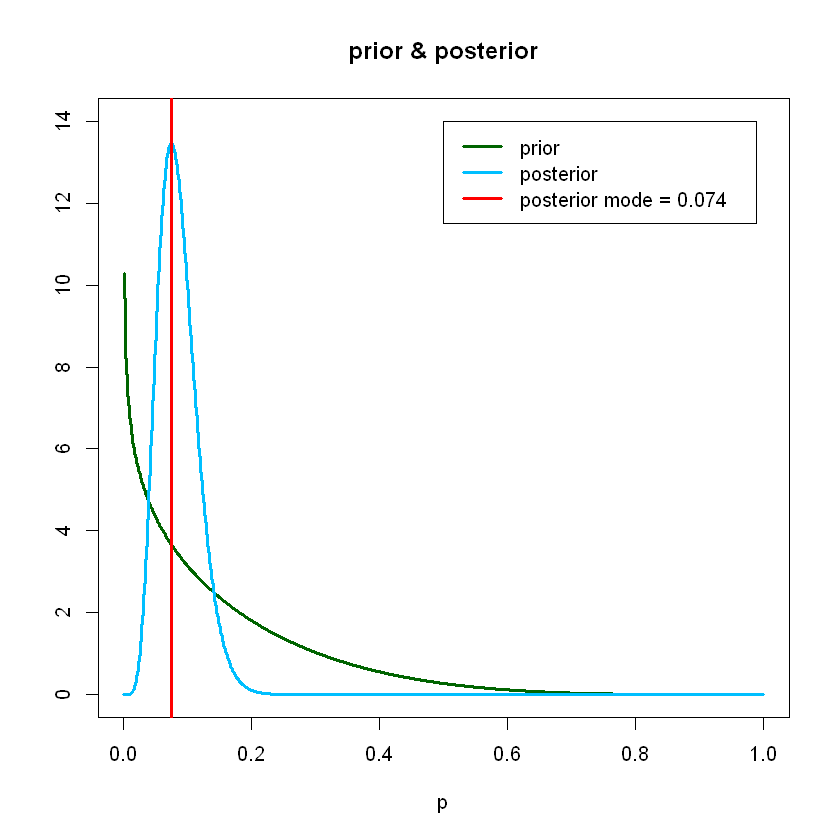

In [81]:
prior <- function(p) dbeta(x = p, shape1 = alpha.prior, shape2 = beta.prior)
posterior <- function(p) dbeta(x = p, shape1 = alpha.posterior, shape2 = beta.posterior)
mode.posterior <- p.vector[which.max(posterior(p.vector))]
print(paste("most probable value for p (MAP estimator) =", mode.posterior))

plot(p.vector, prior(p.vector), type = "l", lwd = 3, col = "darkgreen", ylim = c(0, 14), main = "prior & posterior", xlab = "p", ylab = "")
lines(p.vector, posterior(p.vector), lwd = 3, col = "deepskyblue")
abline(v = mode.posterior, col = "red", lwd = 2.5)

legend(x = 0.5, y = 14, legend = c("prior", "posterior", sprintf("posterior mode = %.3f", mode.posterior)), lty = rep(1, times = 3), lwd = c(3, 3, 2.5), col = c("darkgreen", "deepskyblue", "red"))

### 1.4: bayesian hypothesis testing
To perform an hypothesis testing in the bayesian way we first need to define a null hypothesis to test; in our case we set:
- Null hypothesis $H_0$: $p \geq p_0$, where $p$ and $p_0$ are the failure probabilities of the new and old tests respectively. If $H_0$ is accepted then the new test isn't better than the old one.
- Alternative hypothesis $H_1$: $p < p_0$, i.e. the new test is better than the old one.        
In a bayesian setting we can easily compute the probability that $p\geq p_0$ using the integral of the posterior; in order to prove/disprove the null hypothesis to a given significance $\alpha$, then, it suffices to compare $\alpha$ with
\begin{equation}
  P(H_0: p\geq p_0) = \int_{p_0}^1 P(p | y) \ \mathrm{d}p
\end{equation}
where $P(p | y) = P(\text{model} | \text{data})$ is the beta posterior computed above.

In [96]:
# we set alpha = 5%
significance <- 0.05 # I use this variable name to avoid confusion with the alpha par. of the beta dist.
p0 <- 0.15 # see problem text for the values of p_0 and of the significance

prob.hyp.testing <- integrate(posterior, p0, 1)$value
print(paste("P(p >= p_0) =", prob.hyp.testing))
test <- prob.hyp.testing >= p0

if (test) {
    print(sprintf("since %.3f is greater than or equal to %.3f we accept the null hypothesis", prob.hyp.testing, p0))
    } else {
        print(sprintf("since %.3f is less than  %.3f we reject the null hypothesis", prob.hyp.testing, p0))
}
    

[1] "P(p >= p_0) = 0.0312793302979552"
[1] "since 0.031 is less than  0.150 we reject the null hypothesis"


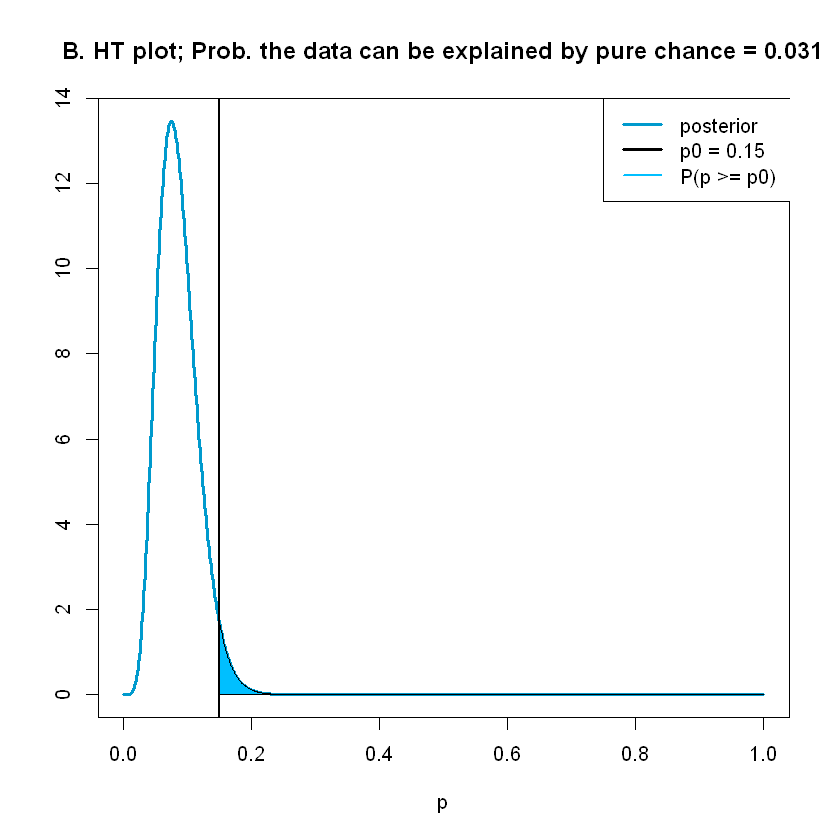

In [74]:
plot(p.vector, posterior(p.vector), type = "l", col = "deepskyblue3", lwd = 3, xlab = "p", ylab = "", main = sprintf("B. HT plot; Prob. the data can be explained by pure chance = %.3f", prob.hyp.testing))
abline(v = p0, col = "black", lwd = 2)
polygon(x = c(p0, p0, p.vector[p.vector >= p0]), y = c(0, posterior(p0), posterior(p.vector[p.vector >= p0])), col = "deepskyblue")

legend(x = 0.75, y = 14, legend = c("posterior", sprintf("p0 = %.2f", p0), "P(p >= p0)"), lty = rep(1, times = 3), lwd = c(3, 3, 2), col = c("deepskyblue3", "black", "deepskyblue"))

### 1.5 frequentist hypothesis testing
Once again we compare a certain probability with the chosen significance, but this time we rely on the likelihood rather than on the posterior. In the frequentist setting in this case the null hypothesis $H_0$ is "the data is generated by the binomial likelihood with $p=p_0$"; if this likelihood predicts that the probability of observing the data we actually observed/something more extreme ($y/n \leq 6/75$) is smaller than the significance then $H_0$ is rejected.       
To recap: we reject the null hypothesis (i.e. the new test is better to the chosen significance level) if
\begin{equation}
  \text{p-value} = P_{\text{binom}}(y \leq 6 | p = p_0 = 0.15, N = n = 75) = \sum_{i = 0}^6 P_{\text{binom}}(i | p = p_0, N = n) < \alpha
\end{equation}
Note: in practice there's no need to actually perform the sum of `dbinom` since `pbinom` takes care of this for us.

In [120]:
p.value <- pbinom(6, size = n, prob = p0)
# p.value <- sum(dbinom(0:6, size = n, prob = p0)) # if we want to be explicit
print(paste("p value =", p.value))

if (p.value < significance) {
    print(sprintf("since %f is less than %f we reject the null hypothesis", p.value, significance))
} else {
    print(sprintf("since %f is greater than or equal to %f we accept the null hypothesis", p.value, significance))
}

[1] "p value = 0.0543533033542315"
[1] "since 0.054353 is greater than or equal to 0.050000 we accept the null hypothesis"


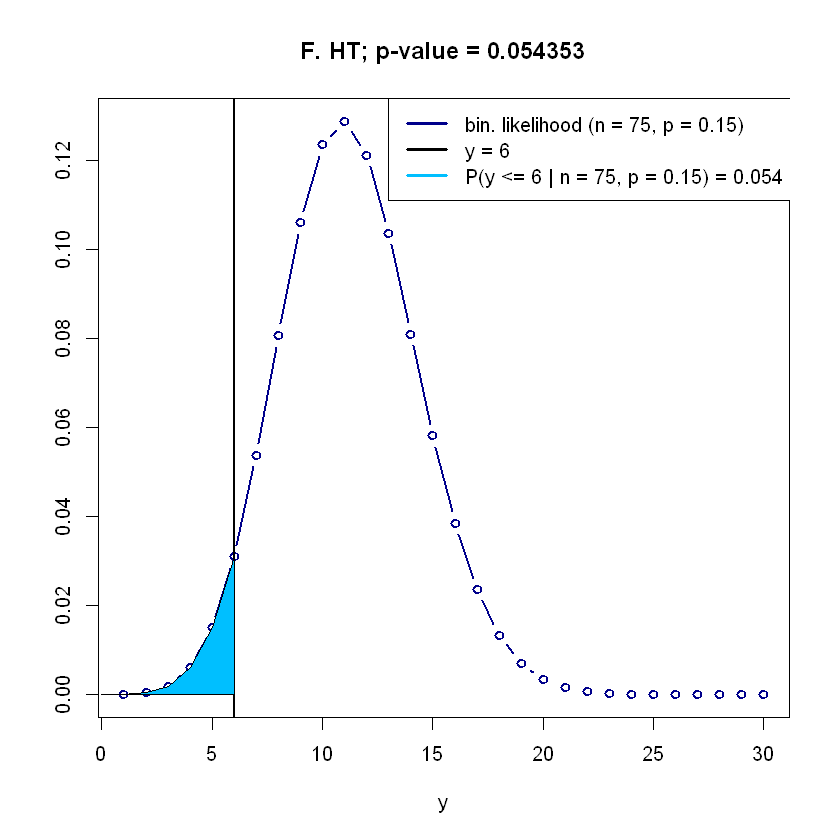

In [166]:
y.vector <- 1:30 # y can only have integer values
fht.vector <- dbinom(y.vector, size = n, prob = p0)

plot(y.vector, fht.vector, type = "b", col = "darkblue", lwd = 2, xlab = "y", ylab = "", main = sprintf("F. HT; p-value = %f", p.value))
abline(v = y, col = "black", lwd = 2)
polygon(x = c(0, y.vector[y.vector <= y], y), y = c(0, fht.vector[y.vector <= y], 0), col = "deepskyblue")

legend(x = 13, y = 0.134, legend = c(sprintf("bin. likelihood (n = %i, p = %.2f)", n, p0), sprintf("y = %i", y), sprintf("P(y <= %i | n = %i, p = %.2f) = %.3f", y, n, p0, p.value)), lty = rep(1, times = 3), col = c("darkblue", "black", "deepskyblue"), lwd = rep(2.5, times = 3))

## Ex.2: Poisson distribution

## Ex. 3: water quality